:::{.column-body-outset}
<h1 style="color: #00205b; font-family: 'Georgia';">Forecasting Demand: Unveiling the Future of Product Sales and Crafting the Optimal Inventory Strategy</h1>
<author style="color: #00205b; font-family: 'Georgia';">By: <a href="https://www./">Simon Tagbor</a></author>
<date style="color: #00205b; font-family: 'Georgia';">2024-01-21</date>
:::


<blockquote class="blockquote">
<p>
One of the core focus of downstream supply chain operations involves a key responsibility – the ability to navigate the ever-changing landscape of customer demand. Supply chain professionals have adopted statiscal techqniques that ebable them to infer the demand of products based on historical data. This process is relatively straightforward when dealing with smaller product categories and stable demand patterns. However, challenges arise in larger product categories with constantly shifting consumer demands, posing scalability issues for traditional forecasting methods.
</p>
<p>
The traditional approach involves observing the distribution and variability of historical data from ERP systems, combined with expert intuition. Yet, as businesses grow, reducing guesswork in demand forecasting becomes important. The decisions made in inventory optimization can significantly impact costs.
</p>
<p>
In this notebook, I will guide you through building a demand forecasting model to predict product demand based on historical data. Moreover, I’ll demonstrate how this model can be leveraged for inventory optimization, covering concepts like reorder points, safety stock, and economic order quantity (EOQ).
</p>
<p>
Throughout this project, we will address two key business questions:
</p>
<ol>
<li>
<em>What is the demand forecast for the top selling product in the next 24 months?</em>
</li>
<li>
<em>What is the optimal inventory level for the product?</em>
</li>
</ol>
<p>
Join me on this exploration as we seek answers, and feel free to share your thoughts and feedback on my approach.
</p>
<p>You can find the source code for this project at my <a href="https://github.com/Simontagbor/supply-chain-demand-forecast">github page.</a> You can also find the Jupyter notebook and the dataset on my <a href="https://www.kaggle.com/simontagbor/british-airways-predictive-ml">kaggle page</a>.</p>
</blockquote>

<details>
<summary style="font-weight:bold;">
Click to Read Executive Summary on Research Findings
</summary>
<div style="
    font-size: 1.8vw; 
    color: #333; 
    padding: 1.5vw; 
    margin: 1.7vw 0; 
    border-left: 0.35vw solid #7792f9; 
    line-height: 1.6; 
    position: relative; 
    background: #e9f5ff;">
<h2 class="anchored">
Executive Summary
</h2>
<p>
After building and testing the demand forecasting model, we discovered trends, seasonalities and holiday effects on the top-selling product based on the dataset provided we also found the optimal inventory policy for the top-selling product:
</p>
<ul>
<li>
Given the zero variance observed in the product price, The Demand for the <code>product Card ID 365</code> is expected to remain fairly stable within the next two years with cyclical dips in sales within the third quarter of each year(2015 and 2016). it might be worth looking into these top predictors of demand outcomes to control the dips and ultimately improve sales outcomes
</li>
</ul>
<div style="display: grid; grid-template-columns: auto auto; padding: 10px; background-color: white; width:85%; margin-left: 9%;">
<div style="font-size: 1.5vw; text-align: left;">
<ol type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="2" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="3" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="4" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="5" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="6" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="7" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="8" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="9" type="1">
<li>Pending
</li></ol></div>
<div style="font-size: 1.5vw; text-align: left;">
<ol start="10" type="1">
<li>Pending
</li></ol></div>
</div>
<ul>
<li>
Based on the Economic Order Quantity Model(EOQ) the optimal inventory policy is
</li>
<p>
</p>
</ul>
<h2 class="anchored">
Potential Application of Insights
</h2>
<p>
</p>
<p>
</p>
</div>
</details>

<h2>Project Outline</h2>
<p>For this project, I completed the following tasks:</p>

- [x] Performed Exploratory Data Analysis.
- [x] Cleaned and Prepared the data for modeling.
- [x] Conducted Time Series Modeling With Prophet.
- [x] Evaluated the model performance.
- [x] Interpret the model results and answer the business questions.


<h2>Problem Statement</h2>
<em>Large product categories and constantly shifting consumer demand patterns introduce a scaling challenge for traditional demand forecasting techniques. There is a need for an approach that reduces the level of guesswork and reduces the avoidable costly outcomes of poor inventory optimizations.</em>

<h2>Project Dependencies</h2>


In [1]:
#| code fold true
# import project libraries
import pandas as pd
import numpy as np # for linear algebra
import math # for math operations 

import seaborn as sns # for plotting

# handling files
import os 
import sys 

# data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Model Building and Fitting
from sklearn.ensemble import RandomForestClassifier
from prophet import Prophet



# Model Evaluation and Tuning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # for plotting
import squarify # for tree maps

<h1>Eploratory Data Analysis</h1>
<p>
The working <a href="#">dataset</a> contains entries of customer demand information The data contains 53 features (columns)
</p>
<p>
To understand the data, I performed exploratory data analysis. I used the following techniques to understand the data:
</p>
<ul class="task-list">
<li><input type="checkbox" checked="">Visual inspection of data.</li>
<li><input type="checkbox" checked="">Exploratory Data Visualizations. (Univariate and Bivariate)</li>
</ul>

<h2>Visual Inspection of Data</h2>

In [21]:
df = pd.read_csv("data/DataCoSupplyChainDataset.csv", encoding="ISO-8859-1")
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class


<p>To explore the spread of the data, we will use the describe() method to get the summary statistics of the data.</p>

In [3]:
# retrieve the number of columns and rows
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


<details><summary>Click to see some Notable Observation of the Data</summary>
<ol type="1">
<li><p>Aproximately <code>55%</code> of orders had late delivery risks.</p></li>
<li><p>Aproximately <code>75%</code> of products cost <code>$199.99</code></p></li>
<li><p>All the products are available.</p></li>
<li><p>75% of customers bought goods worth at least <code>$247.40</code></p></li>
</ol>
<p>
Further inspection of the data will help us understand the data better.
</p>
</details>


<h2 class="anchored">
Data Preprocessing
</h2>
<p>
To Forecast the demand based on the available data, we will focus on historical sales data, and product attributes like; stock level, and product category, we will also analyze the impact of other variables that contribute to demand patterns including geographic factors, customer segments and lead time.
</p>
<h4 class="anchored">
Preprocessing Tasks
</h4>

- [x] Drop irrelevant columns
- [x] Drop rows with missing values
- [x] Create new features
- [x] Convert categorical features to numerical features

<p>Based on the above, we will drop the majority of the columns that are not relevant for forecasting the demand and extract new features from the existing columns
</p>



<h3>
Drop Irrelevant Columns
</h3>

In [22]:
#| code fold true
# drop irrelevant columns
def drop_columns(df, columns_to_drop):
    try:
        df = df.drop(columns=columns_to_drop)
        print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(df.columns)}")
        return df
    except KeyError as e:
        print(f"""Column(s): {e} not found in dataframe.
              
            No columns dropped.
            Please Check that the column names are correct.""")
        return df

# Specify the columns to keep
colums_to_keep = ['Days for shipping (real)', 
                  'Days for shipment (scheduled)',
                  'Customer Country',
                  'Sales per customer',
                  'Delivery Status', 
                  'Late_delivery_risk', 
                  'Customer City',
                  'Customer Segment',
                  'Sales','Shipping Mode',
                  'Type', 'Product Card Id',
                  'Customer Zipcode', 
                  'Product Category Id', 
                  'Product Name',                    
                  'Product Price',
                  'Market', 
                  'Product Status',
                  'shipping date (DateOrders)',]

# Specify the columns to drop
columns_to_drop = [col for col in df.columns if col not in colums_to_keep ]

df = drop_columns(df, columns_to_drop)

34 columns dropped successfully. Number of columns remaining: 19


<h3>Drop Rows with Missing Values</h3>

In [23]:
#| code fold true
# drop customer Zip code.
df = df.drop(columns=['Customer Zipcode'])

<h4>A Quick Spot Check for Missing Values</h4>

In [24]:
### Check for Missing values
df.isnull().sum()

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Customer City                    0
Customer Country                 0
Customer Segment                 0
Market                           0
Sales                            0
Product Card Id                  0
Product Category Id              0
Product Name                     0
Product Price                    0
Product Status                   0
shipping date (DateOrders)       0
Shipping Mode                    0
dtype: int64

<h3>Create New Features</h3>
<p>The dataset contains a `shipping date` column which is a `DateTime` object from which we can extract `Month`, `Year`, `Day` and `Day of Week` that can be useful in our analysis.</p>

- [x] `Month` - to capture the months per sale.
- [x] `Year` - to capture the year per sales.
- [x] `Day` - to capture the day per sales.
- [x] `Day of Week` - to capture the day of the week per sales.

<p>
I chose <code>Shipping Date</code> over the <code>Order date</code> because it reflects fulfilled demand while the latter captures interest. (the customer could cancel the order)
</p>

In [25]:
#| code fold true
# Create month, Year, Day, and Weekday columns from Shipping Date
def extract_date_parts(df, date_column, prefix):
    try:
        df[date_column] = pd.to_datetime(df[date_column])
        df[f'{prefix} Year'] = df[date_column].dt.year
        df[f'{prefix} Month'] = df[date_column].dt.month
        df[f'{prefix} Day'] = df[date_column].dt.day
        df[f'{prefix} Weekday'] = df[date_column].dt.weekday
        # verify and notify that the columns have been created
        if f'{prefix} Year' in df.columns and f'{prefix} Month' in df.columns and f'{prefix} Day' in df.columns and f'{prefix} Weekday' in df.columns:
            print(f" Success! Columns Created: {prefix} Year, {prefix} Month, {prefix} Day, and {prefix} Weekday")
            return df
        else:
            print("Error creating columns. Please check that the date column name is correct.")
    except Exception as e:
        print(f"Error creating columns: {e}")
        return df

# Use the function to extract date parts
df = extract_date_parts(df, 'shipping date (DateOrders)', 'Shipping')

 Success! Columns Created: Shipping Year, Shipping Month, Shipping Day, and Shipping Weekday


In [10]:
# display the shape of the dataframe
df.shape

(180519, 21)

<p>Now we have 21 new columns and 180519 entries (rows) in the dataset.</p>

<h3>Convert Categorical Features to Numerical Features</h3>
<p>The nature of categorical data makes it unsuitable for future analysis. for instance, machine learning models can't work with categorical values for customer origins like `UK`, `USA`, `France`, etc. We will convert these categorical values to numerical values using the `LabelEncoder` from the `sklearn` library.</p>

<p>I will also perform a <a href="#"> one-hot encoding</a> technique on categorical features for future machine learning modeling tasks.</p>

<p> I wrote a `prepare_data()` function that returns two preprocessed dataframes: one that is encoded using a label encoder function and the other encoded using one hot encoding technique.</p>

<p>You can learn about encoding techniques for categorical variables <a href="#">here</a></p>


In [8]:
# Select top selling product
top_product = df['Product Card Id'].value_counts().index[0]
# get top product ID
print(f"Filtering and Encoding Dataset for Top Product ID: {top_product}")

from sklearn.preprocessing import LabelEncoder

def prepare_data(df, product_card_id, categorical_cols, columns_to_drop):
    """
    Prepare a DataFrame for bivariate analysis and machine learning by applying label encoding and one-hot encoding to categorical columns and dropping specified columns.

    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    product_card_id (int): The product card ID to filter the DataFrame on.
    categorical_cols (list of str): The names of the categorical columns to apply encoding to.
    columns_to_drop (list of str): The names of the columns to drop from the DataFrame.

    Returns:
    pandas.DataFrame: The label encoded DataFrame for bivariate analysis.
    pandas.DataFrame: The one-hot encoded DataFrame for machine learning.
    """
    try:
        df_copy = df[df['Product Card Id'] == product_card_id].copy()  # create a copy

        # label encoding
        label_encoder = LabelEncoder()
        df_label_encoded = df_copy.copy()

        # Apply label encoding to categorical variables in place
        for col in categorical_cols:
            df_label_encoded[col] = label_encoder.fit_transform(df_label_encoded[col])

        # Drop specified columns
        df_label_encoded = df_label_encoded.drop(columns=columns_to_drop)

        # one-hot encoding
        df_one_hot_encoded = pd.get_dummies(df_copy, columns=categorical_cols)

        # Drop specified columns
        df_one_hot_encoded = df_one_hot_encoded.drop(columns=columns_to_drop)
        print("Data preparation successful.")
        return  df_one_hot_encoded, df_label_encoded
    except Exception as e:
        print(f"Error preparing data: {e}")
        return None, None

# Use the function to prepare the data for bivariate analysis
categorical_cols = ['Type', 'Customer Segment', 
                    'Delivery Status', 
                    'Customer City', 
                    'Market',
                    'Shipping Mode']

columns_to_drop = ['Product Name', 
                   'Customer Country', 
                   'shipping date (DateOrders)', 
                   'Product Card Id', 
                   'Product Category Id', 
                   'Product Status', 
                   'Product Price']

# drop columns and encode data for correlation martrix and Machine learning
onehot_encode_df, label_encode_df = prepare_data(df, top_product, categorical_cols, columns_to_drop)

# rename Type column to Payment Type
label_encode_df = label_encode_df.rename(columns={'Type': 'Payment Type'})
onehot_encode_df = onehot_encode_df.rename(columns={'Type': 'Payment Type'})

Filtering and Encoding Dataset for Top Product ID: 365


Data preparation successful.


<h4>Confirm Encoding of Dataset </h4>

In [10]:
# validate the label encoding
label_encode_df.dtypes

Payment Type                  int64
Days for shipping (real)      int64
Sales per customer          float64
Delivery Status               int64
Late_delivery_risk            int64
Customer City                 int64
Customer Segment              int64
Market                        int64
Sales                       float64
Shipping Mode                 int64
Shipping Year                 int32
Shipping Month                int32
Shipping Day                  int32
Shipping Weekday              int32
dtype: object

In [11]:
# validate the one-hot encoding
onehot_encode_df.dtypes

Days for shipping (real)          int64
Sales per customer              float64
Late_delivery_risk                int64
Sales                           float64
Shipping Year                     int32
                                 ...   
Market_USCA                        bool
Shipping Mode_First Class          bool
Shipping Mode_Same Day             bool
Shipping Mode_Second Class         bool
Shipping Mode_Standard Class       bool
Length: 590, dtype: object

<h4>Finally...Data Preprocessing Completed Successfully!!</h4>


<!-- insert gif -->
<img src="https://media.giphy.com/media/jIv6pfqKiIvHPYZO6y/giphy.gif?cid=790b76114sdadclwy3mcxlm3o08nf63hxm28relnkbokg8ue&ep=v1_gifs_search&rid=giphy.gif&ct=g" alt="gif" style="width: 100%; height: auto;">	

<p> The dataset is now ready for further analysis and modeling. I will now proceed to conduct exploratory data visualizations to understand the data better.</p>

<h2>Exploratory Data Visualizations</h2>
<p>To highlight the distributions of the individual variables as well as the relationship between the variables and the target variables, I used the following techniques:</p>

- [x] Univariate Analysis
- [x] Exploratory Time Series Analysis

<h3>Univariate Analysis</h3>
<p>Univariate analysis is the simplest form of data analysis where the data being analyzed contains only one variable. Since it's a single variable, it doesn't deal with causes or relationships. The main purpose of univariate analysis is to describe the data and find patterns that exist within it.</p>

<h4>Visualizing the Distribution of the Dataset</h4>

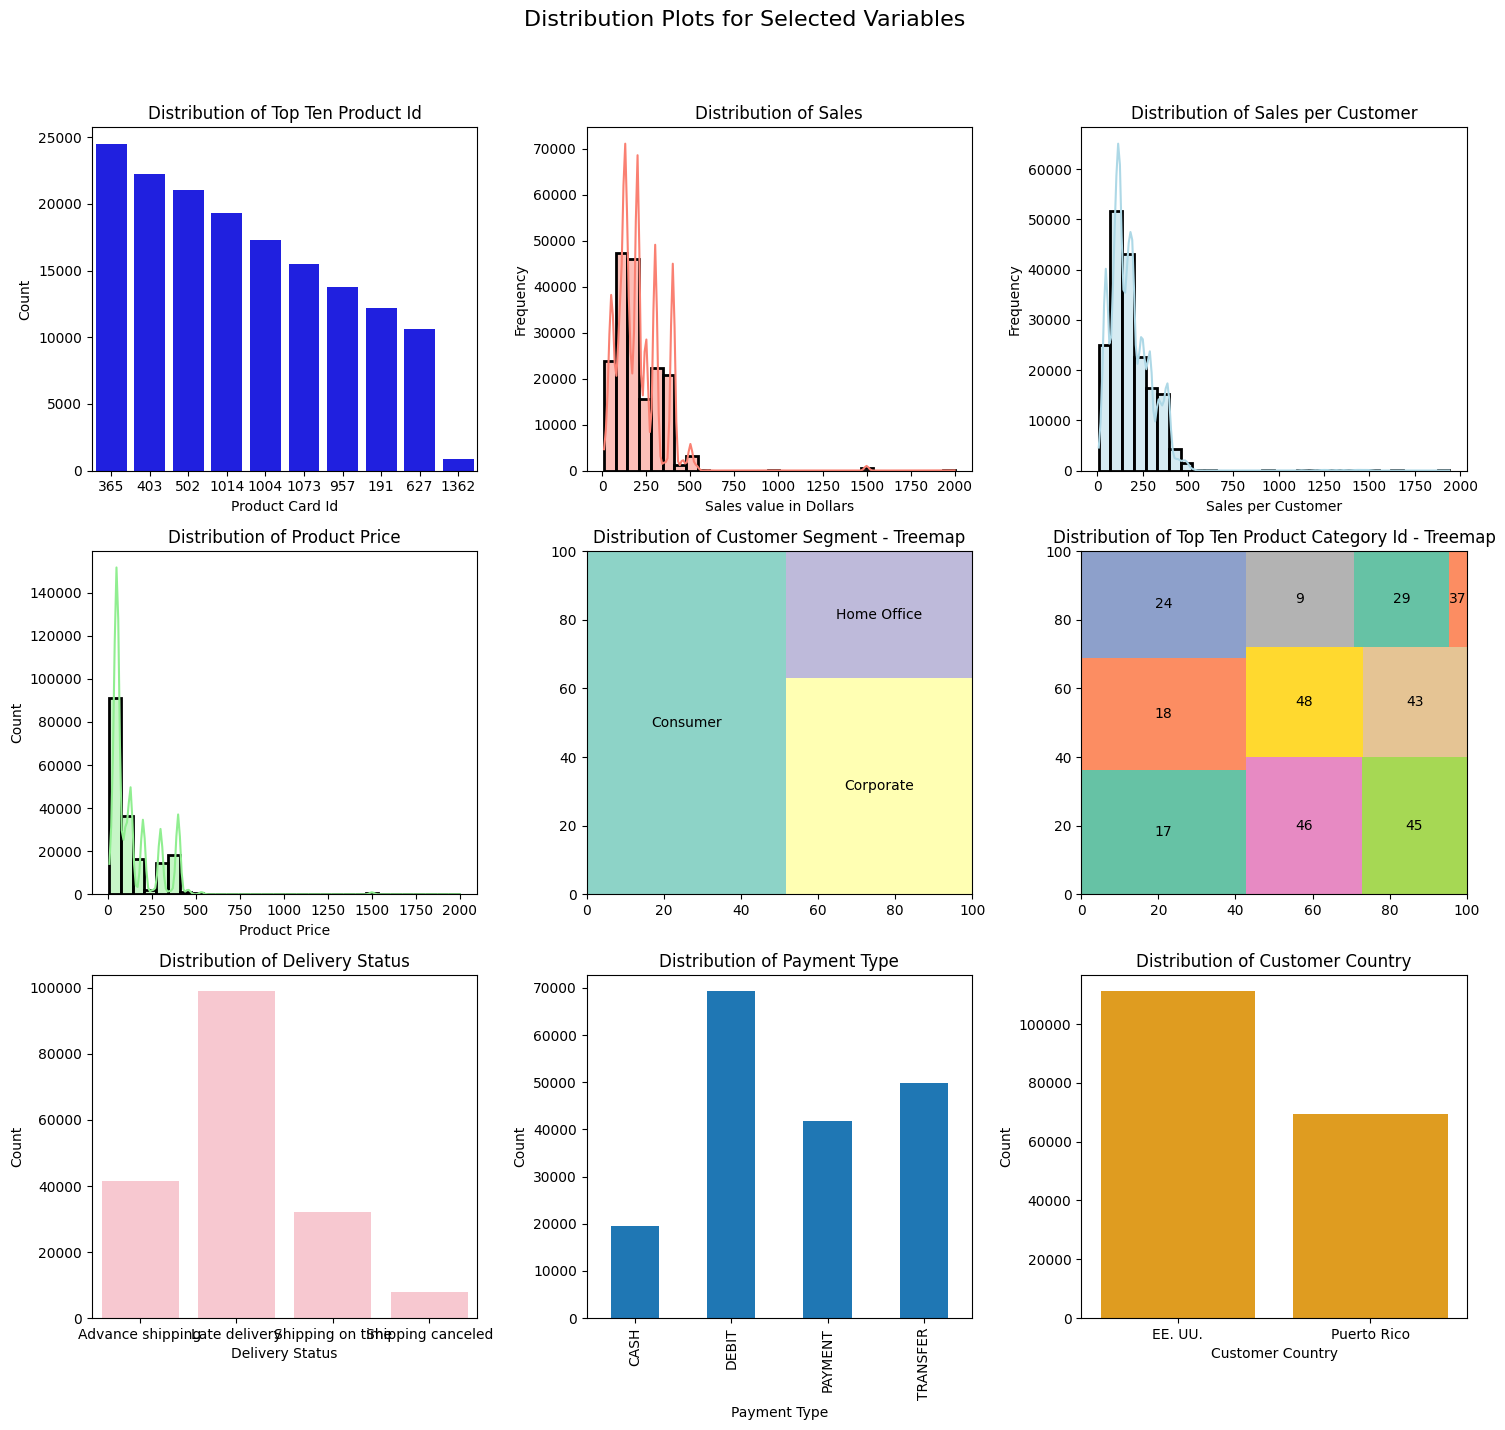

In [13]:
#| code fold true
# Set up the grid layout
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Distribution Plots for Selected Variables', 
             fontsize=16)
# Create a copy of the DataFrame
df_copy = df.copy()


# Plotting  the top ten products per Product Card Id
sns.countplot(data=df_copy, x='Product Card Id',
                color='blue', ax=axes[0, 0], 
                order=df_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0, 0].set_title('Distribution of Top Ten Product Id')
axes[0, 0].set_xlabel('Product Card Id')
axes[0, 0].set_ylabel('Count')


# Plotting Value of sales in  dollars
sns.histplot(data=df_copy, x='Sales', 
             kde=True, color='salmon', 
             bins=30, linewidth=2,
             ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sales')
axes[0, 1].set_xlabel('Sales value in Dollars')
axes[0, 1].set_ylabel('Frequency')


# Plotting Sales Value per customer
sns.histplot(data=df_copy, x='Sales per customer',
             bins=30, kde=True, linewidth=2,
             color='lightblue', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Sales per Customer')
axes[0, 2].set_xlabel('Sales per Customer')
axes[0, 2].set_ylabel('Frequency')

# Ploting the distribution of Product Price
sns.histplot(data=df_copy, x='Product Price', bins=30, kde=True, 
             color='lightgreen', linewidth=2, ax=axes[1, 0])

axes[1, 0].set_title('Distribution of Product Price')
axes[1, 0].set_xlabel('Product Price')

# ploting a tree map for Customer Segment
squarify.plot(sizes=df_copy['Customer Segment'].value_counts(), 
              label=df_copy['Customer Segment'].value_counts().index, 
              color=sns.color_palette("Set3"), ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Customer Segment - Treemap')

# ploting a tree map for Top Ten Product Category Id
squarify.plot(sizes=df_copy['Product Category Id'].value_counts().iloc[:10],
                label=df_copy['Product Category Id'].value_counts().iloc[:10].index,
                color=sns.color_palette("Set2"), ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Top Ten Product Category Id - Treemap')

# Plotting the distribution of Delivery Status
sns.countplot(data=df_copy, x='Delivery Status',
                color='pink', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Delivery Status')
axes[2, 0].set_xlabel('Delivery Status')
axes[2, 0].set_ylabel('Count')


# Plotting the distribution Payment Type with stacked bar chart
df_copy.groupby(['Type'])['Type'].count().plot(kind='bar', 
                                               stacked=True,
                                               ax=axes[2, 1])

axes[2, 1].set_title('Distribution of Payment Type')
axes[2, 1].set_xlabel('Payment Type')
axes[2, 1].set_ylabel('Count')

# Plotting the Distribution of top ten Customer Country
sns.countplot(data=df_copy, x='Customer Country',
                color='orange', ax=axes[2, 2], 
                order=df_copy['Customer Country'].value_counts().iloc[:10].index)
axes[2, 2].set_title('Distribution of Customer Country')
axes[2, 2].set_xlabel('Customer Country')
axes[2, 2].set_ylabel('Count')



# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plots
plt.show()


<details>
<summary>
Click to Read My Observations!
</summary>
<p>
The Top Selling <code>Product ID</code> is <code>365</code> which corresponds to a <code>product name</code>: <code>Perfect Fitness Perfect Rip Deck</code> this indicates a fast-moving product. I will focus the demand forecasting process on this product going forward
</p>
<p>
The distribution of <code>Sales Value</code> and <code>Sales per customer</code> are both positively skewed with a long tail. This indicates that the majority of sales are for low-value products. This is an interesting insight because it may suggest that the majority of customers are price-sensitive.
</p>
<p>
The distribution of <code>Product Price</code> is also positively skewed with a long tail. This means that the majority of products are low-value products.
</p>
<p>
The distribution of <code>Customer Segment</code> indicates that the majority of customers are from the consumer segment.
</p>
</details>

::: {.cell .callout}
**NOTE**: Based on the insight from the univariate analysis, The rest of the analysis and forecasting will focus on the top selling `Product Card Id` (365 ‘Perfect Fitness Perfect Rip Deck’)

:::

<h3>Exploratory Time Series Analysis</h3>
<p>To understand the demand patterns of the top-selling product, I created a time series heatmap to visualize the demand patterns of the top-selling product over time.</p>

<h4>Time Series HeatMap of The Demand(Sales)</h4>

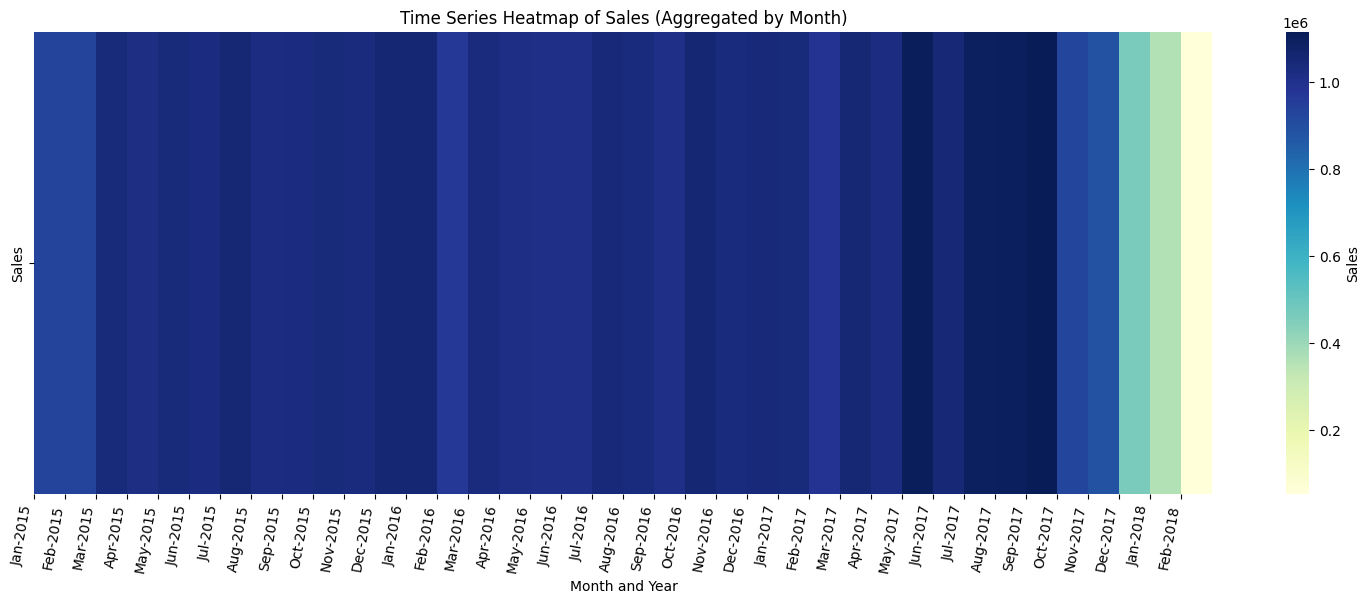

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# extract shipping date (DateOrders) and Sales columns
df_heatmap = df[['shipping date (DateOrders)', 'Sales']]
# Assuming 'df' is your original dataframe

df_heatmap.set_index('shipping date (DateOrders)', inplace=True)
resampled_df = df_heatmap.resample('M').sum()  # Resample to yearly frequency
# Set x-axis ticks to represent months and years
month_labels = [calendar.month_abbr[m.month] + '-' + str(m.year) for m in resampled_df.index]
# Plot the heatmap
plt.figure(figsize=(19, 6))
sns.heatmap(resampled_df.T, cmap='YlGnBu', cbar_kws={'label': 'Sales'})
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=80, ha='right')

plt.title('Time Series Heatmap of Sales (Aggregated by Month)')
plt.xlabel('Month and Year')


plt.show()

<p>Judging from consistency in the shades of the heatmap, we can see that the demand for the top-selling product is fairly stable over time. However, it is interesting to note that the number of sales recorded for the first quarters of <code>2015</code>, <code>2016</code> and <code>2017</code> remained consistent however in 2018 the number of sales recorded in the first quarter dipped significantly. This is an interesting insight that we can explore further.
</p>
<p>
Next, I will use the <code>Prophet</code> library to model the demand for the top-selling product. This will help us understand the cyclical patterns in the demand for the top-selling product
</p>



<h2 class="anchored">
Forecasting Demand of the Top-selling Product with Prophet
</h2>
<p>
Prophet is a forecasting tool developed by Facebook. It is designed for analyzing time series data that display patterns on different time scales such as yearly, weekly, and daily. It also has advanced capabilities for modeling the effects of holidays on a time series and implementing custom seasonalities. see the documentation <a href="#">here</a>
</p>

In [12]:
# | code fold true
# import prophet
from prophet import Prophet

prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})
# Add custom Puerto Rico holidays
# Read the CSV file
holidays_df = pd.read_csv('data/puertorican_holidays.csv')

# Rename the 'Date' column to 'ds' and the 'Name' column to 'holiday'
holidays_df = holidays_df.rename(columns={'Date': 'ds', 'Name': 'holiday'})

# Drop the 'Type' column as it's not needed
holidays_df = holidays_df.drop(columns=['Type'])

# Add 'lower_window' and 'upper_window' columns
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 1

# Convert 'ds' to datetime
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

# Create a Prophet instance and provide the holidays DataFrame
prophet = Prophet(holidays=holidays_df)

prophet.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
future = prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
forecast = prophet.predict(future) 

21:55:33 - cmdstanpy - INFO - Chain [1] start processing
22:30:21 - cmdstanpy - INFO - Chain [1] done processing


<p>
The code above uses the <code>Prophet</code> library to model the demand for the top-selling product. The model is trained on the <code>Sales</code> and <code>Shipping Date</code> columns. The model is then used to forecast the demand for the top-selling product over the next 365 days.
</p>
<p>
The code also included Puerto Rican holidays to account for the impact of holidays on the demand for the top-selling product. This is important because holidays can have a significant impact on demand patterns.
</p>
<p>
You might wonder why Puerto Rican holidays were included in the model. From the univariate analysis conducted earlier, we discovered that most of the orders were coming from Puerto Rico. The <code>forecast</code> variable now contains the forecasted values for the top-selling product. we will work with the variable later but for now, let’s evaluate the accuracy of our prophet model
</p>

<h3>Evaluating the Accuracy of the Time Series Forecast</h3>

<p>To determine the accuracy of the prophet model, we will use the `cross_validationa()` function provided by `Prophet`</p>

In [13]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:12 - cmdstanpy - INFO - Chain [1] done processing


<p>
The <code>cross_validation()</code> function performs cross-validation on the model. It trains the model on a subset of the data and then evaluates the model on the remaining data. This is a good way to evaluate the accuracy of the model. The <code>initial</code> parameter specifies the size of the training set. The <code>period</code> parameter specifies the frequency of the forecast.
</p>
<p>
Let’s visualize the performance of the model
</p>

<Figure size 900x600 with 0 Axes>

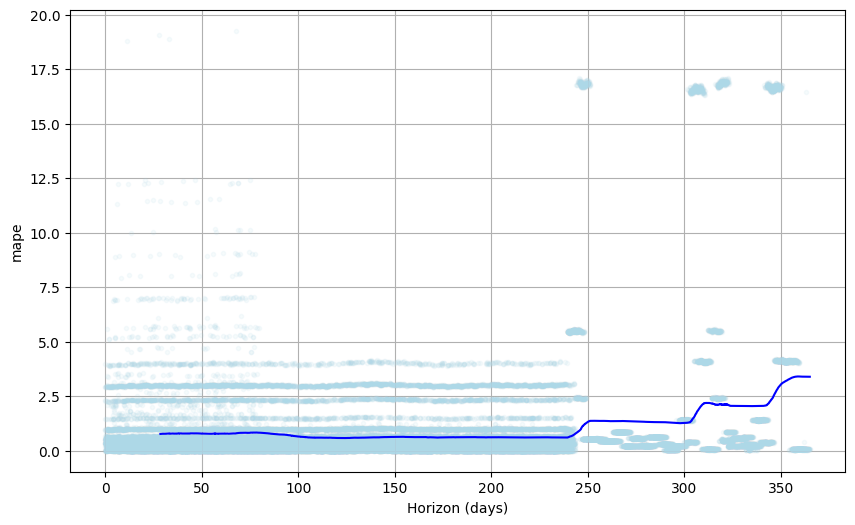

In [14]:
# Plot MAPE
from prophet.plot import plot_cross_validation_metric
#  set fig size
plt.figure(figsize=(9, 6))
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges

<p>
The forecast has lower `MAPE` (Mean Absolute Percentage Error) values for horizons within the 200-day range however the accuracy drops for horizons beyond 250 days. This suggests that the model is making more errors at periods beyond 250 days.
</p>
<p>
The model will be most useful to stakeholders if it can forecast demand beyond 250 days with a lower percentage of errors. Exposing the model to more historical data may help lower the MAPE significantly. nonetheless, let’s explore if there are opportunities to improve the accuracy by finding the best combinations of hyperparameters for the prophet model. I will use a <a href="#">hyperparameter tuning</a> technique to try to optimize the model’s performance.
</p>
<h4 class="anchored">
Finding the Best Hyperparameter Combination for Lower MAPE
</h4>

In [ ]:
#| code fold true
from sklearn.model_selection import ParameterGrid

# Assuming prophet_df is your DataFrame with 'ds' and 'y' columns
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})

# Specify hyperparameter values to try
param_grid = {
    'seasonality_mode': ["additive", 'multiplicative'],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'holidays_prior_scale': [5, 10, 20, 25],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
}

# Generate all combinations of hyperparameters using ParameterGrid
param_combinations = ParameterGrid(param_grid)

<p>
The code above uses the <code>ParameterGrid</code> function from the <code>sklearn</code> library to create a grid of hyperparameters. The grid contains different combinations of hyperparameters for the prophet model.
</p><p>
The code below then uses the <code>cross_validation()</code> function to evaluate the accuracy of the model for each combination of hyperparameters. The code then selects the combination of hyperparameters that results in the lowest MAPE.
</p>

In [ ]:
# | code fold true
from itertools import product
# Store results in a dictionary
results = {}
print(f"trying all {len(param_combinations)} hyperparameter combinations")
# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

for params in param_combinations:
    # Create a Prophet instance with current hyperparameter values
    prophet = Prophet(**dict(zip(param_grid.keys(), params)))

    # Fit the model
    prophet.fit(prophet_df)

    # Perform cross-validation
    df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')


    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv, rolling_window=0)

    # Store metrics in the results dictionary
    results[params] = df_metrics['mape'].mean()


:::{.callout .note}

**NOTE**: The code took a very long time to complete. It tried 128 different combinations of hyperparameters and the best model was the one with the lowest MAPE value.
::: 

<p>
The results are in! The best model had the following hyperparameters:
</p>

In [ ]:
# Find the hyperparameters with the lowest RMSE
best_hyperparams = min(results, key=results.get)
print(f"Best Hyperparameters: {dict(zip(param_grid.keys(), best_hyperparams))}")

<div class="cell-output cell-output-stdout">
<pre><code>Best Hyperparameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.005}</code></pre>
</div>
</div>

<p>Now let’s rebuild the model with the best hyperparameters and evaluate the model’s performance.</p>

In [15]:
tuned_prophet = Prophet(holidays=holidays_df, 
                        seasonality_mode='additive', 
                        seasonality_prior_scale=1, 
                        holidays_prior_scale=5, 
                        changepoint_prior_scale=0.005)
# fit the model
tuned_prophet.fit(prophet_df)
# Create a DataFrame with future dates for forecasting
future = tuned_prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
new_forecast = tuned_prophet.predict(future)

23:02:03 - cmdstanpy - INFO - Chain [1] start processing
23:16:43 - cmdstanpy - INFO - Chain [1] done processing


<h5>Cross Validation of the Best Model</h5>

In [16]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
tuned_df_cv = cross_validation(model=tuned_prophet, initial='730 days', period='365 days', horizon='365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:51:05 - cmdstanpy - INFO - Chain [1] done processing


<p>let’s compare the accuracy of the model before and after hyperparameter tuning.</p>

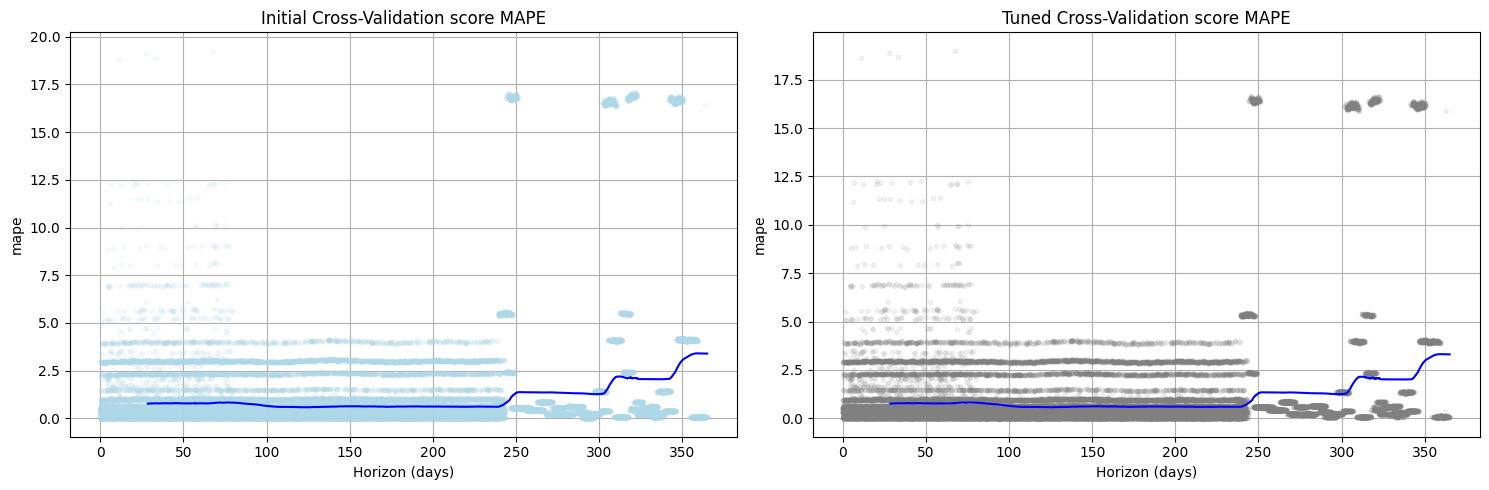

In [17]:
# | code fold true
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first cross-validation metric
fig1 = plot_cross_validation_metric(df_cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[0].set_title('Initial Cross-Validation score MAPE')

# Plot the second cross-validation metric
fig2 = plot_cross_validation_metric(tuned_df_cv, metric='mape', ax=axs[1])
fig2.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig2.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E9')  # Change color of the dot edges
# add title
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()

<p>Not Exactly the outcome I was expecting but the tuned model’s performance remains consistent with the previous model. This may suggest that the model is not sensitive to the hyperparameters. Nonetheless, the model is still useful for forecasting demand for the top-selling product.</p>

<h4 class="anchored">
Forecast Results
</h4>
<p>As indicated earlier, the <code>forecast</code> variable contains the forecasted values of our <code>Sales</code> time series. Based on this forecast we will calculate the optimal inventory policy for this specific product.</p>
<p>
The <code>forecast</code> variable is a dataframe that contains the following columns:
</p>

In [18]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,American Citizenship Day,American Citizenship Day_lower,American Citizenship Day_upper,Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-03 00:00:00,189.503452,59.70575,380.739390,189.503452,189.503452,0.0,0.0,0.0,0.0,...,-1.288207,-1.288207,-1.288207,33.801001,33.801001,33.801001,0.0,0.0,0.0,220.974183
1,2015-01-03 03:30:00,189.646216,54.96060,375.707409,189.646216,189.646216,0.0,0.0,0.0,0.0,...,-1.373629,-1.373629,-1.373629,33.618634,33.618634,33.618634,0.0,0.0,0.0,221.460580


<p>Before calculating the optimal inventory policy, let’s visualize the forecasted sales data. To have a feel for the seasonalities and cycles in the forecasted sales data</p>

<h4 class="anchored">
Visualizing Forecasted Sales
</h4>

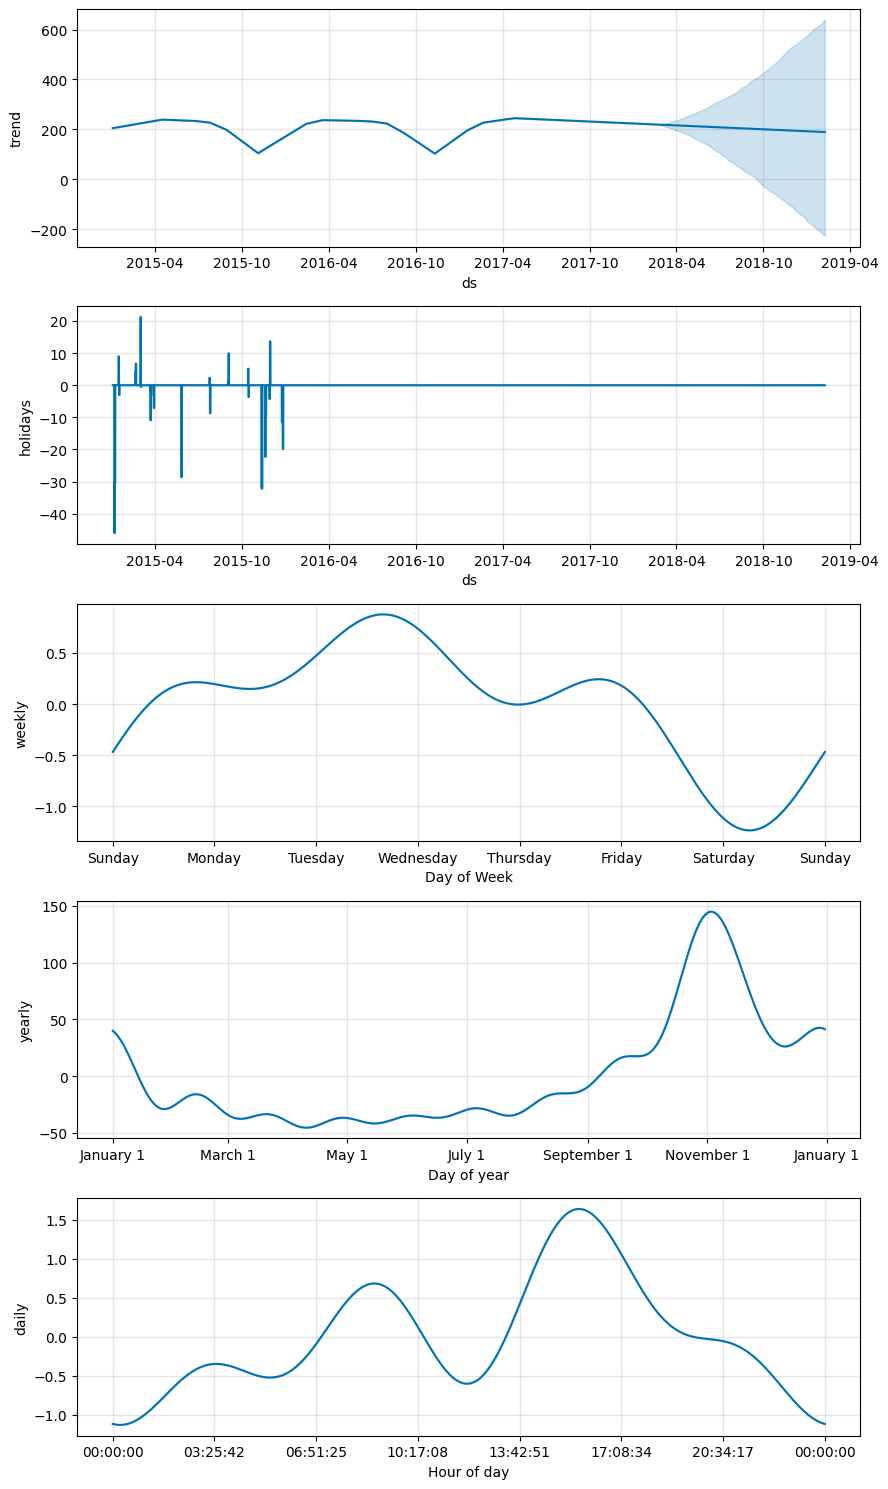

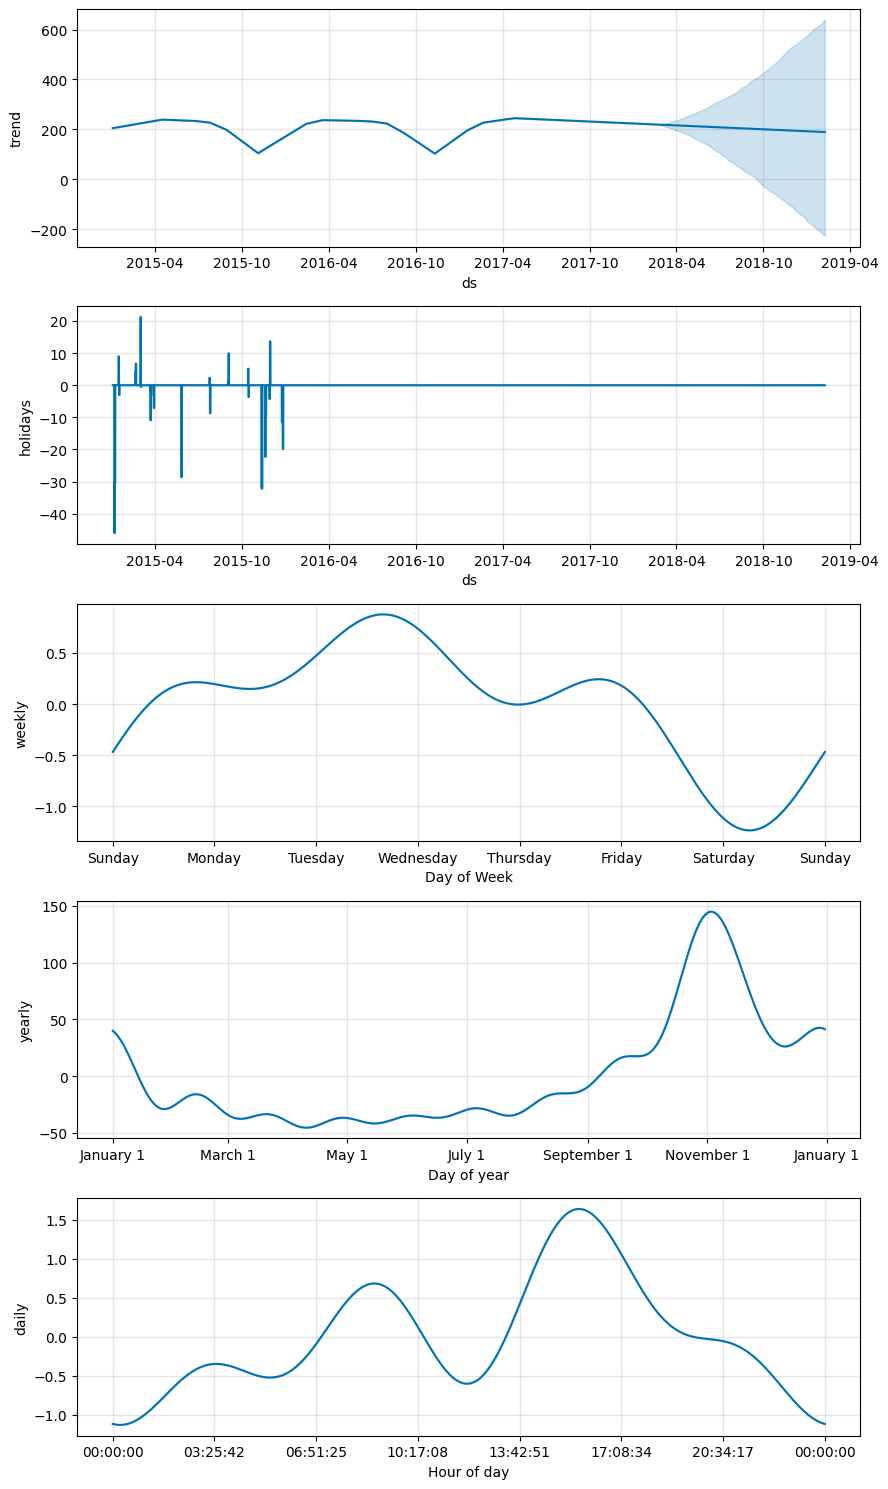

In [19]:
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot the forecast
tuned_prophet.plot_components(new_forecast)

<h4 class="anchored">
Answering the Business Question with forecasted Sales
</h4>


<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExeWJlamcxOTJnM3ZyeDllcXE4MW1lOHpmMndrMnJpMms0YnZ4aWNwcyZlcD12MV9naWZzX3NlYXJjaCZjdD1n/xT5LMWNOjGqJzUfyve/giphy.gif" alt="gif" style="width: 100%; height: auto;">	


><em><h5>What is the demand forecast for the top selling product in the next 24 months?</h5></em>
<p>
<p>The sales trend between <code>2015</code> and <code>2017</code> marks a cycle where sales for the product remained relatively stable during the second and third quarters of each year and then dipped slightly in October with a sharp increase between November and December.
</p>
<p>The forecasted sales for the next 24 months, on the other hand, indicate a very stable demand pattern.
<p>
The zero variance observed in the product price may account for the relatively stable sales pattern forecasted for `2018` and `2019`. It might also be worth investigating the factors that may account for the cyclical dips between 2015 and 2017
</p>
<p>
We can also observe the impact of the Puerto Rican holidays on the forecasted sales.
</p>
<h2 class="anchored">
Finding Optimal Inventory Policy Based on Forecasted Demand
</h2>
<p>
Now that we have forecasted the demand for the top-selling product, we can use the forecasted demand to calculate the optimal inventory policy for the product.</p>
<p> 
Finding the optimal inventory policy will help us determine the <a href= "#">Reorder Point</a>, <a href=#>safety stock</a>, and <a href="#" >Economic Order Quantity</a>(EOQ) for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.
</p>

<h3>Re Order Point</h3>
The reorder point is the inventory level at which we should reorder more stock. 
`ROP`  is calculated as the product of the average sales per day and the lead time (also referred to as `Lead Time Demand`) plus the `Safety stock`.

$$ Reorder\ Point = \text{Lead\ Time\ Demand} + \text{Safety\ Stock} $$


let's Find the Lead Time Demand

$$ \text{Lead Time Demand} = \text{Average Sales Per Day} \times \text{Lead Time} $$

In [27]:

# Extract average forecasted sales per day
average_forecasted_sales = new_forecast['yhat'].mean()
print(f"Average Forecasted Sales: {average_forecasted_sales}")
# Extract lead time
lead_time_data = df.copy()
lead_time_data['lead_time'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']  # noqa: F821

# Extract the average lead time
average_lead_time = lead_time_data['lead_time'].mean()
print(f"Average Lead Time: {average_lead_time}")

lead_time_demand = average_forecasted_sales * average_lead_time
print(f"Lead Time Demand: {lead_time_demand}")

Average Forecasted Sales: 209.8761684793452
Average Lead Time: 0.5658074773292562
Lead Time Demand: 118.74950543882827


<p>One final piece to the Reorder Point puzzle is the ` Safety Stock`. The safety stock is the extra stock that is kept on hand to mitigate the risk of stockouts due to uncertainties in demand and lead time.</p>

$$ \text{Safety Stock} = (\text{Maximum Daily Sales} \times \text{Maximum Lead Time}) - (\text{Average Sales Per Day} \times \text{Average Lead Time}) $$


In [28]:
# find maximum daily forecasted sales
max_daily_forecasted_sales = new_forecast['yhat'].max()
print(f"Maximum Daily Forecasted Sales: {max_daily_forecasted_sales}")

# find maximum lead time
max_lead_time = lead_time_data['lead_time'].max()
print(f"Maximum Lead Time: {max_lead_time}")

# calculate safety stock
safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
print(f"Safety Stock: {safety_stock}")

Maximum Daily Forecasted Sales: 375.38211369017046
Maximum Lead Time: 4
Safety Stock: 1382.7789493218536


<p>Finally, we can calculate the reorder point for the top-selling product.</p>

<h4>Putting It All Together</h4>

In [29]:
# calculate reorder point
reorder_point = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {reorder_point}")

The Optimal Reorder Point for the Top-selling Product is: 1501.5284547606818


<p> As indicated by the result, the reorder point for the top-selling product is `1501` units, which means that we should reorder more stock when the inventory level reaches `1501` units. This will help us ensure that we have enough stock on hand to meet customer demand while minimizing inventory costs.</p>

<h3>Economic Order Quantity (EOQ)</h3>
<p> Alternatively, we can use the <a href="https://dclcorp.com/blog/inventory/economic-order-quantity-eoq/">Economic Order Quantity (EOQ) model</a> to calculate the optimal order quantity for the top-selling product. The EOQ model helps us determine the optimal order quantity that minimizes the total inventory costs.</p>

<p>Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs, of holding inventory (e.g., storage costs, opportunity costs).</p>



The Economic Order Quantity (EOQ) formula is given by:

EOQ = sqrt((2 * D * S) / H)

Where:
- \( D \) is the demand rate (number of units demanded),
- \( S \) is the ordering cost per order,
- \( H \) is the holding cost per unit per year.

This formula helps in determining the optimal order quantity that minimizes the total inventory costs.
